In [ ]:
'''
Would Recommend Mounting Google Drive and storing the input/output files there using the folder structure required by nnU-Net.
This is especially useful in Google Colab, where GPU sessions may disconnect or crash — keeping your data on Drive ensures you dont lose progress.
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -e .
!pip install nnunetv2
!pip install --upgrade git+https://github.com/MIC-DKFZ/nnUNet.git

Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta

  Cloning https://github.com/MIC-DKFZ/nnUNet.git to /tmp/pip-req-build-xtk94rba
  Running command git clone --filter=blob:none --quiet https://github.com/MIC-DKFZ/nnUNet.git /tmp/pip-req-build-xtk94rba
  Resolved https://github.com/MIC-DKFZ/nnUNet.git to commit f1851fbaf2c53dcb51b079b60a01de528a7d0c17
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
# For creating dataset.json file containing metadata (Run only if dataset.json doesnt exists)

import os
import json
from collections import OrderedDict

base_path = "/content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset300_LISA"
images_path = os.path.join(base_path, "imagesTr")
labels_path = os.path.join(base_path, "labelsTr")

image_files = sorted([f for f in os.listdir(images_path) if f.endswith("_0000.nii.gz")])
label_files = sorted([f for f in os.listdir(labels_path) if f.endswith(".nii.gz")])

image_ids = [f.replace("_0000.nii.gz", "") for f in image_files]
label_ids = [f.replace(".nii.gz", "") for f in label_files]

common_ids = sorted(list(set(image_ids).intersection(set(label_ids))))

dataset = OrderedDict()
dataset['name'] = "LISA"
dataset['description'] = "Low-field hippocampus segmentation"
dataset['tensorImageSize'] = "4D"
dataset['reference'] = "MICCAI LISA 2024"
dataset['licence'] = "CC-BY-SA 4.0"
dataset['release'] = "0.0"
dataset['modality'] = {"0": "MRI"}
dataset['labels'] = {"background" : 0 , "hippocampus" : 1}
dataset['numTraining'] = len(common_ids)
dataset['numTest'] = 0
dataset['training'] = [
    {
        "image": f"./imagesTr/{id}_0000.nii.gz",
        "label": f"./labelsTr/{id}.nii.gz"
    } for id in common_ids
]
dataset['test'] = []

with open(os.path.join(base_path, "dataset.json"), "w") as f:
    json.dump(dataset, f, indent=4)

print(f"Created dataset.json with {len(common_ids)} training cases.")

In [ ]:
# Setting Environment Variables for nnUNet

import os

os.environ["nnUNet_raw"] = "/content/drive/MyDrive/nnUNet/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/content/drive/MyDrive/nnUNet/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/content/drive/MyDrive/nnUNet/nnUNet_results"

print("nnU-Net environment variables have been set.")

nnU-Net environment variables have been set.


In [ ]:
# Label Correction/Remapping

import nibabel as nib
import os
import numpy as np

label_dir = "/content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset300_LISA/labelsTr"

for fname in os.listdir(label_dir):
    if fname.endswith(".nii.gz"):
        path = os.path.join(label_dir, fname)
        img = nib.load(path)
        data = img.get_fdata()

        data[data == 2.0] = 1.0

        new_img = nib.Nifti1Image(data.astype(np.uint8), img.affine, img.header)
        nib.save(new_img, path)

print("All labels fixed: 2.0 replaced with 1.0")

All labels fixed: 2.0 replaced with 1.0


*   -d 300 for Dataset ID/Name which is 300 "Dataset300_LISA"
*   -c 2d for setting configuration type of mode like here it's 2d UNnet

In [ ]:
# Preprocessing nnUNet on data

!nnUNetv2_plan_and_preprocess -d 300 -c 2d

Fingerprint extraction...
Dataset300_LISA
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [164.5 226.  192.5], 3d_lowres: [164, 226, 192]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 57, 'patch_size': (np.int64(256), np.int64(224)), 'median_image_size_in_voxels': array([226. , 192.5]), 'spacing': array([1., 1.]), 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [False], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order': 3, 'orde

In [ ]:
# Checking If GPU is available

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [ ]:
# nnUNet Training

!nnUNetv2_train 300 2d 0


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-07-23 08:42:44.531274: Using torch.compile...
2025-07-23 08:42:47.436324: do_dummy_2d_data_aug: False
2025-07-23 08:42:47.443815: Creating new 5-fold cross-validation split...
2025-07-23 08:42:47.452905: Desired fold for training: 0
2025-07-23 08:42:47.456298: This split has 44 training and

In [ ]:
# Copied The validation/test samples to another folder for safety of data

import os
import shutil

# Using splited data(as shown in splits_final.json) from Fold 0 only now
val_ids = [
    "LISA_0009", "LISA_0020", "LISA_0040", "LISA_0046",
    "LISA_0050", "LISA_0055", "LISA_0061", "LISA_0063",
    "LISA_1003", "LISA_1008", "LISA_1009"
]

src_dir = "/content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset300_LISA/imagesTr"
dst_dir = "/content/images_val_fold0"

os.makedirs(dst_dir, exist_ok=True)

for val_id in val_ids:
    filename = f"{val_id}_0000.nii.gz"
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(dst_dir, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        print(f"Copied: {filename}")
    else:
        print(f"File not found: {filename}")

Copied: LISA_0009_0000.nii.gz
Copied: LISA_0020_0000.nii.gz
Copied: LISA_0040_0000.nii.gz
Copied: LISA_0046_0000.nii.gz
Copied: LISA_0050_0000.nii.gz
Copied: LISA_0055_0000.nii.gz
Copied: LISA_0061_0000.nii.gz
Copied: LISA_0063_0000.nii.gz
Copied: LISA_1003_0000.nii.gz
Copied: LISA_1008_0000.nii.gz
Copied: LISA_1009_0000.nii.gz


*  -i Path to input images for prediction
*  -o Path where output/predicted segmentations will be saved
*  -tr Trainer class name used during model training default is nnUNetTrainer
*  -f Fold number of the model to use for prediction like here its 0


In [ ]:
# nnUNet Prediction

!nnUNetv2_predict \
  -i /content/images_val_fold0 \
  -o /content/drive/MyDrive/nnUNet/predictions \
  -d 300 \
  -c 2d \
  -tr nnUNetTrainer \
  -f 0


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 11 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 11 cases that I would like to predict

Predicting LISA_0009:
perform_everything_on_device: True
100% 159/159 [00:05<00:00, 27.67it/s]
sending off prediction to background worker for resampling and export
done with LISA_0009

Predicting LISA_0020:
perform_everything_on_device: True
100% 159/159 [00:06<00:00, 24.84it/s]
sending off prediction to background worker for resampling and export
done with LISA_0020

Predicting LISA_0040:
perform_everything_on_device: True
100

In [ ]:
# Copy the labels(only matching files that model predicted on) files from orignal labels folder to separate folder

import os
import shutil

val_ids = [
    "LISA_0009", "LISA_0020", "LISA_0040", "LISA_0046",
    "LISA_0050", "LISA_0055", "LISA_0061", "LISA_0063",
    "LISA_1003", "LISA_1008", "LISA_1009"
]

src_dir = "/content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset300_LISA/labelsTr"
dst_dir = "/content/labels_for_evaluation"

os.makedirs(dst_dir, exist_ok=True)

for val_id in val_ids:
    filename = f"{val_id}.nii.gz"
    src_path = os.path.join(src_dir, filename)
    dst_path = os.path.join(dst_dir, filename)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        print(f"Copied: {filename}")
    else:
        print(f"File not found: {filename}")

In [ ]:
# Evaluation of prediction

!nnUNetv2_evaluate_folder \
  /content/labels_for_evaluation \
  /content/drive/MyDrive/nnUNet/predictions \
  -djfile /content/drive/MyDrive/nnUNet/nnUNet_raw/Dataset300_LISA/dataset.json \
  -pfile /content/drive/MyDrive/nnUNet/nnUNet_results/Dataset300_LISA/nnUNetTrainer__nnUNetPlans__2d/plans.json

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer


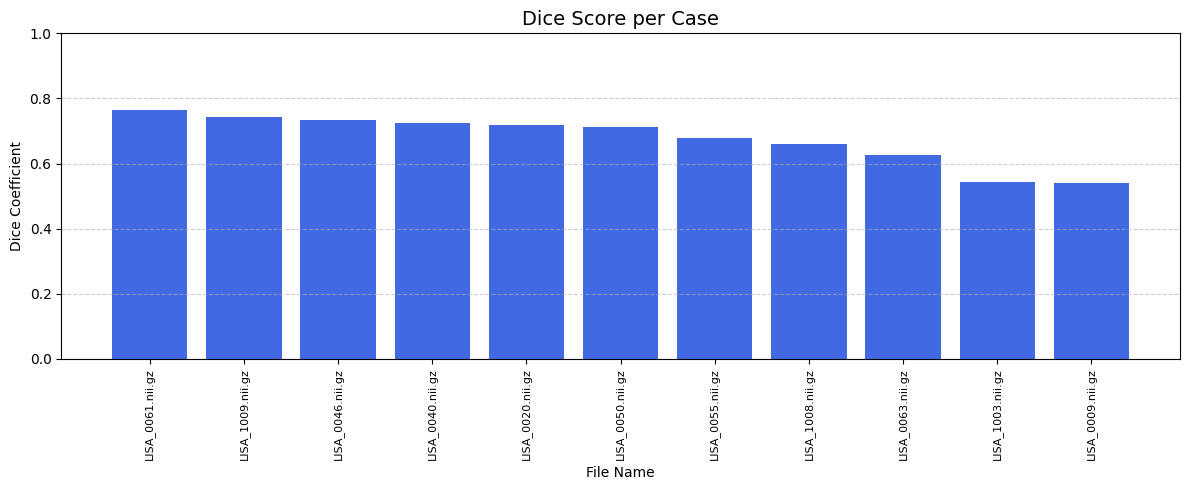

In [ ]:
# Dice coeffient of Each predicted file

import matplotlib.pyplot as plt
import pandas as pd
import json

with open('/content/drive/MyDrive/nnUNet/predictions/summary.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data["metric_per_case"])

df['Dice'] = df['metrics'].apply(lambda x: x['1']['Dice'])
df['File Name'] = df['prediction_file'].apply(lambda x: x.split('/')[-1])

df_sorted = df.sort_values(by="Dice", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(df_sorted["File Name"], df_sorted["Dice"], color='royalblue')
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.title("Dice Score per Case", fontsize=14)
plt.ylabel("Dice Coefficient")
plt.xlabel("File Name")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation of model

import json

summary_path = '/content/drive/MyDrive/nnUNet/predictions/summary.json'
with open(summary_path, 'r') as f:
    summary = json.load(f)

mean_metrics = summary.get("mean", {})

print("Model-Level Evaluation (Mean across all cases):\n")
for class_id, metrics in mean_metrics.items():
    for metric, value in metrics.items():
        print(f"  {metric}: {round(value, 4)}")
    print()

Model-Level Evaluation (Mean across all cases):

  Dice: 0.6772
  FN: 973.7273
  FP: 540.4545
  IoU: 0.5165
  TN: 7616788.4545
  TP: 1623.4545
  n_pred: 2163.9091
  n_ref: 2597.1818



In [ ]:
# Evaluation of each file

import pandas as pd
import json

with open('/content/drive/MyDrive/nnUNet/predictions/summary.json', 'r') as f:
    data = json.load(f)

case_metrics = data["metric_per_case"]

records = []
for case in case_metrics:
    file_name = case["prediction_file"].split("/")[-1]
    metrics = case["metrics"]["1"]

    TP = metrics["TP"]
    FP = metrics["FP"]
    FN = metrics["FN"]

    dice = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0.0
    iou = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0

    records.append({
        "File Name": file_name,
        "Dice": round(dice, 4),
        "Jaccard": round(iou, 4),
        "Recall": round(recall, 4),
        "Precision": round(precision, 4)
    })

df = pd.DataFrame(records)

print(df)
df.to_csv('/content/per_case_metrics.csv', index=False)

           File Name    Dice  Jaccard  Recall  Precision
0   LISA_0009.nii.gz  0.5411   0.3709  0.4298     0.7300
1   LISA_0020.nii.gz  0.7199   0.5623  0.6288     0.8418
2   LISA_0040.nii.gz  0.7253   0.5690  0.6301     0.8545
3   LISA_0046.nii.gz  0.7343   0.5802  0.9172     0.6122
4   LISA_0050.nii.gz  0.7120   0.5528  0.7295     0.6954
5   LISA_0055.nii.gz  0.6797   0.5148  0.6528     0.7089
6   LISA_0061.nii.gz  0.7642   0.6184  0.6898     0.8567
7   LISA_0063.nii.gz  0.6269   0.4566  0.5146     0.8019
8   LISA_1003.nii.gz  0.5445   0.3741  0.4553     0.6771
9   LISA_1008.nii.gz  0.6596   0.4921  0.6775     0.6426
10  LISA_1009.nii.gz  0.7420   0.5898  0.7161     0.7699
